In [1]:
import plac
from tqdm import tqdm
import numpy as np
from PIL import Image
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import SGD
from torchvision.datasets import MNIST 
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid

import pdb; 

import os, time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import itertools
import pickle
import imageio
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from skimage.transform import rescale, resize, downscale_local_mean

import math
from math import nan

import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

%matplotlib inline
import os

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install import-ipynb
import import_ipynb
import importlib

%cd "/content/drive/My Drive/Colab Notebooks/Linear_approx"
import functions
importlib.reload(functions)

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=867c8e888afeb8244444e86e7ec98e91b13d9395eb91c4553c48b55bf7da91f7
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
/content/drive/My Drive/Colab Notebooks/Linear_approx
importing Jupyter notebook from functions.ipynb
importing Jupyter notebook from functions.ipynb


<module 'functions' from 'functions.ipynb'>

In [3]:
class VAE(nn.Module):
  def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
    super(VAE, self).__init__()
    
    # encoder part
    self.fc1 = nn.Linear(x_dim, h_dim1)
    self.fc2 = nn.Linear(h_dim1, h_dim2)
    self.fc31 = nn.Linear(h_dim2, z_dim)
    self.fc32 = nn.Linear(h_dim2, z_dim)
    # decoder part
    self.fc4 = nn.Linear(z_dim, h_dim2, bias = False)
    self.fc5 = nn.Linear(h_dim2, h_dim1, bias = False)
    self.fc6 = nn.Linear(h_dim1, x_dim, bias = False)
    
  def encoder(self, x):
    h = F.relu(self.fc1(x))
    h = F.relu(self.fc2(h))
    return self.fc31(h), self.fc32(h) # mu, log_var
  
  def sampling(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu) # return z sample
      
  def decoder(self, z):
    h = F.relu(self.fc4(z))
    h = F.relu(self.fc5(h))
    return F.sigmoid(self.fc6(h)) 
  
  def forward(self, x):
    mu, log_var = self.encoder(x.view(-1, 784))
    z = self.sampling(mu, log_var)
    return self.decoder(z), mu, log_var

In [4]:
# data_loader
img_size = 28
batch_size = 100

transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
])

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./data/MNIST', download=True, train=False, transform=transform),
    batch_size=1, shuffle=True, drop_last = True)

In [75]:
# network
code_dim = 20
vae = VAE(x_dim=784, h_dim1= 500, h_dim2=500, z_dim=20)
if torch.cuda.is_available():
    vae.cuda()

vae.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/Linear_approx/MNIST_VAE_Gen_20_BCE_White_2.pwf'))
W = list(vae.parameters())
W0 = W[8]
W1 = W[9]
W2 = W[10]

net_param = [20, 500, 500, 784] #expansive generator
_,s0,_ = torch.svd(W0)
_,s1,_ = torch.svd(W1)
_,s2,_ = torch.svd(W2)

W0 = W0/s0[0];
W1 = W1/s1[0];
W2 = W2/s2[0];
weight_matrix_d3 = functions.weight_mats(net_param)
weight_matrix_d3.W[0] = W0.data
weight_matrix_d3.W[1] = W1.data
weight_matrix_d3.W[2] = W2.data

signal_example = enumerate(test_loader)
i, (signal_example_data,target_example_data) = next(signal_example)


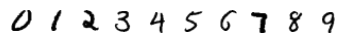

In [83]:
num_max= 10
signal_example_num = torch.zeros(num_max,28,28);
for num in range(num_max):
# num = 5
  while target_example_data[0].numpy() != num:
    i, (signal_example_data,target_example_data) = next(signal_example)
    signal_example_num[num] = 1-signal_example_data[0][0]

fig, axs = plt.subplots(1,num_max)
for i in range(num_max):
  axs[i].imshow(signal_example_num[i], cmap = 'gray')
  axs[i].axis('off')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


done with a number
done with a number
done with a number
done with a number
done with a number
done with a number
done with a number
done with a number
done with a number
done with a number


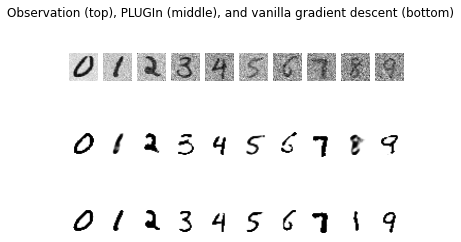

In [88]:
#denoising
step = 1
max_itt = 10000
tol = 1e-13
param = functions.algo_parameter(step, max_itt, tol)
tot_trials = 3

# num = 6


z_min_quasi = torch.zeros(1,20).cuda
z_min_exact = torch.zeros(1,20).cuda


signal_str = torch.norm(signal_example_num[num])
noise_list =torch.linspace(signal_str/500,signal_str/50, 10)

fig, axs = plt.subplots(3,len(noise_list))
fig.suptitle('Observation (top), PLUGIn (middle), and vanilla gradient descent (bottom)')

for i in range(len(noise_list)):
  noise = noise_list[i]
  meas_error_quasi = math.inf
  meas_error_exact = math.inf 
  num = i
  A = torch.eye(28*28,28*28).cuda()
  y0 = torch.matmul(A, signal_example_num[num].cuda().reshape(784)) +noise*torch.randn(784).cuda()
  for j in range(tot_trials):
    
    axs[0,i].imshow(y0.reshape(28,28).cpu().detach().numpy(),cmap='gray')
    axs[0,i].axis('off')
    zk = functions.quasi_grad(net_param, param, vae.decoder, y0, weight_matrix_d3, A, 0)
    meas_error = torch.norm(torch.matmul(A,vae.decoder(zk[0]).reshape(784)) - y0)/(784**.5)
    if meas_error < meas_error_quasi:
      z_min_quasi = zk[0].clone()
      meas_error_quasi = meas_error
    
    axs[1,i].imshow(vae.decoder(z_min_quasi).reshape(28,28).cpu().detach().numpy(),cmap='gray')
    axs[1,i].axis('off')

    

    epoch = 0;
    succ_error = 1
    z = torch.randn(code_dim).cuda()
    z.requires_grad=True
    z_temp = torch.zeros(1,code_dim).cuda()
    while epoch<max_itt and succ_error>tol:
      z_temp = z.clone()
      y_pred = torch.matmul(A, vae.decoder(z).reshape(784))
      loss=(y_pred-y0).pow(2).mean()

      loss.backward()

      with torch.no_grad():
        z -= 1000.*z.grad
        z.grad.zero_()

      epoch = epoch +1; 
      succ_error = torch.norm(z_temp-z)/torch.norm(z)
    meas_error = torch.norm(torch.matmul(A,vae.decoder(z).reshape(784)) - y0)/(784**.5)
    if meas_error < meas_error_exact:
      z_min_exact = z.clone()
      meas_error_exact = meas_error 
    axs[2,i].imshow(vae.decoder(z_min_exact).reshape(28,28).cpu().detach().numpy(),cmap='gray')
    axs[2,i].axis('off')
  print('done with a number')

# fig.savefig("/content/drive/My Drive/Colab Notebooks/Linear_approx/denoise_result.png",dpi = 300, bbox_inches='tight')



In [85]:
fig.savefig("/content/drive/My Drive/Colab Notebooks/Linear_approx/denoise_result_all.png",dpi = 300, bbox_inches='tight')



In [91]:
i = 8
tot_trials = 1
noise = noise_list[i]
meas_error_quasi = math.inf
meas_error_exact = math.inf 
num = i
A = torch.eye(28*28,28*28).cuda()
y0 = torch.matmul(A, signal_example_num[num].cuda().reshape(784)) +noise*torch.randn(784).cuda()
for j in range(tot_trials):

  axs[0,i].imshow(y0.reshape(28,28).cpu().detach().numpy(),cmap='gray')
  axs[0,i].axis('off')
  zk = functions.quasi_grad(net_param, param, vae.decoder, y0, weight_matrix_d3, A, 0)
  meas_error = torch.norm(torch.matmul(A,vae.decoder(zk[0]).reshape(784)) - y0)/(784**.5)
  if meas_error < meas_error_quasi:
    z_min_quasi = zk[0].clone()
    meas_error_quasi = meas_error

  axs[1,i].imshow(vae.decoder(z_min_quasi).reshape(28,28).cpu().detach().numpy(),cmap='gray')
  axs[1,i].axis('off')



  epoch = 0;
  succ_error = 1
  z = torch.randn(code_dim).cuda()
  z.requires_grad=True
  z_temp = torch.zeros(1,code_dim).cuda()
  while epoch<max_itt and succ_error>tol:
    z_temp = z.clone()
    y_pred = torch.matmul(A, vae.decoder(z).reshape(784))
    loss=(y_pred-y0).pow(2).mean()

    loss.backward()

    with torch.no_grad():
      z -= 1000.*z.grad
      z.grad.zero_()

    epoch = epoch +1; 
    succ_error = torch.norm(z_temp-z)/torch.norm(z)
  meas_error = torch.norm(torch.matmul(A,vae.decoder(z).reshape(784)) - y0)/(784**.5)
  if meas_error < meas_error_exact:
    z_min_exact = z.clone()
    meas_error_exact = meas_error 
  axs[2,i].imshow(vae.decoder(z_min_exact).reshape(28,28).cpu().detach().numpy(),cmap='gray')
  axs[2,i].axis('off')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [63]:
1/0.005

200.0

In [93]:
fig
fig.savefig("/content/drive/My Drive/Colab Notebooks/Linear_approx/denoise_result_all.png",dpi = 300, bbox_inches='tight')


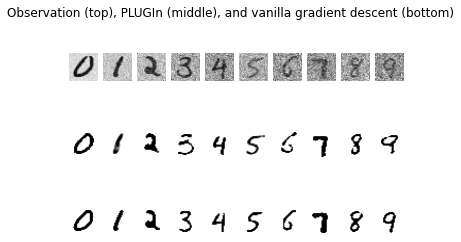

In [94]:
fig